In [139]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Subset
from torchvision.datasets import CIFAR10
from vit_pytorch import ViT, SimpleViT
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

## 首先读入CIFAR10数据

In [125]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 导入数据集
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# 对数据集进行处理
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## 接下来我们定义不同的模型

In [126]:
class ViTModel(nn.Module):
    # 定义一个ViT的模型
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, dropout):
        super(ViTModel, self).__init__()
        self.vit = ViT(image_size=image_size,
            patch_size=patch_size,
            num_classes=num_classes,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            dropout=dropout
        )

    def forward(self, x):
        return self.vit(x)
    
class SimpleViTModel(nn.Module):
    # 定义一个SimpleViT的模型
    def __init__(self, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim):
        super(SimpleViTModel, self).__init__()
        self.simple_vit = SimpleViT(image_size=image_size,
            patch_size=patch_size,
            num_classes=num_classes,
            dim=dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
        )

    def forward(self, x):
        return self.simple_vit(x)

class CNNModel(nn.Module):
    # 定义一个两层卷积网络的模型
    def __init__(self, input_channels, hidden_channels, num_classes):
        super().__init__()
        self.conv_and_pooled1 = nn.Sequential(
                        nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=2),
                        nn.MaxPool2d(2,2))
        self.conv_and_pooled2 = nn.Sequential(
                        nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=2),
                        nn.MaxPool2d(2,2))
        self.linear = nn.Linear(7*7*hidden_channels, num_classes)
        self.flatten = nn.Flatten()
    
    def forward(self, x):
        conv1_x = self.conv_and_pooled1(x)
        conv2_x = self.conv_and_pooled2(conv1_x)
        flatten_x = self.flatten(conv2_x)
        forward_x = self.linear(flatten_x)
        return forward_x

## 接下来我们定义一个类，来对不同模型进行评估

In [127]:
class ValAccurency:
    def __init__(self, n_train, model_type):
        # 使用模型中的前n_train个数据对模型进行训练
        if model_type == 'ViT':
            # 对于ViT模型进行评价
            self.model = ViTModel(image_size=32, patch_size=4, num_classes=10, \
                             dim=128, depth=2, heads=8, mlp_dim=512, dropout=0.1)
        elif model_type == 'SimpleViT':
            # 对于SimpleViT模型进行评价
            self.model = SimpleViTModel(image_size=32, patch_size=4, num_classes=10, \
                             dim=128, depth=2, heads=8, mlp_dim=512)
        elif model_type == 'CNN':
            # 对于CNN模型进行评价
            self.model = CNNModel(input_channels=3, hidden_channels=10, num_classes=10)
        elif model_type == 'ResNet':
            # 对于ResNet18模型进行评价
            self.model = torchvision.models.resnet18(pretrained=False)
            
        self.time = 0 # 创建变量来记录训练所需的时间
        subset_indices = range(n_train)
        data_to_train = Subset(train_dataset, subset_indices)
        
        self.train_loader = DataLoader(data_to_train, batch_size=64, shuffle=False, num_workers=2)
        device = torch.device("mps")# 使用 mps来进行运算的加速
        self.model.to(device)
        
    def __train__(self):
        # 完成在对应数据集下的模型的训练
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
        self.model.train()
        time_begin = time.time()
        num_epochs = 10
        for epoch in range(num_epochs):
            for images, labels in self.train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        
        # 对于每个模型训练完成后进行播报
        print('train finished for one num_data')
        time_end = time.time()
        self.time = time_end - time_begin
        
    def __time__(self):
        # 返回训练时所耗费的时间
        with torch.no_grad():
            if self.time == 0:
                print('还未训练！！！')
            else:
                return self.time
        
    def __eval__(self):
        # 完成对应模型在对应训练集上的评估
        self.model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        return accuracy

## 下面可以再定义一个函数直接来返回不同模型的运行时间与对应的准确率

In [128]:
def train_time_acc(model_type):
    # 返回给定模型下不同训练集大小模型在测试集上的准确率
    # 返回的五个结果分别对应训练集的大小为10000，20000，30000，40000，50000
    time, acc = [], []
    for i in range(1,6):
        num_data = i * 10000
        ValModel = ValAccurency(num_data, model_type)
        ValModel.__train__()
        time.append(ValModel.__time__())
        acc.append(ValModel.__eval__())
    return time, acc

## 获得不同模型不同大小数据集下运行时间与对应的准确率

In [130]:
time_CNN, acc_CNN = train_time_acc('CNN')
time_ViT, acc_ViT = train_time_acc('ViT')
time_SViT, acc_SViT = train_time_acc('SimpleViT')

train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data


In [132]:
time_ResNet, acc_ResNet = train_time_acc('ResNet')

train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data
train finished for one num_data


## 接下来我们将结果可视化

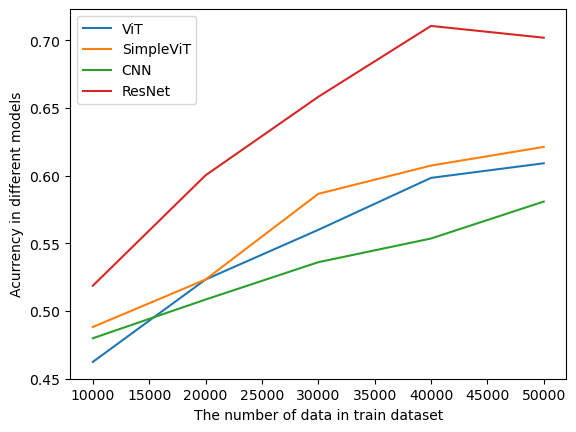

In [149]:
fig, ax = plt.subplots()
x = np.linspace(10000,50000,5)
ax.plot(x, acc_ViT, label='ViT') 
ax.plot(x, acc_SViT, label='SimpleViT')
ax.plot(x, acc_CNN, label='CNN')
ax.plot(x, acc_ResNet, label='ResNet')

ax.set_xlabel('The number of data in train dataset') 
ax.set_ylabel('Acurrency in different models') 
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.savefig('AIfinal.png')
plt.show()

In [150]:
print('训练CNN使用的时间', time_CNN)
print('训练ViT使用的时间', time_ViT)
print('训练ResNet使用的时间', time_ResNet)
print('训练SimpleViT使用的时间', time_SViT)

训练CNN使用的时间 [150.61633706092834, 160.59931015968323, 166.59584999084473, 174.7579689025879, 184.16234707832336]
训练ViT使用的时间 [193.57423210144043, 243.75465989112854, 297.88932514190674, 774.3853876590729, 1189.0868427753448]
训练ResNet使用的时间 [215.37599396705627, 295.2139570713043, 351.5060930252075, 348.9210612773895, 406.3809320926666]
训练SimpleViT使用的时间 [189.55984830856323, 237.6520528793335, 286.64898586273193, 334.5461940765381, 384.09912300109863]
